# 神经网络基本概念

简单补充一些神经网络的基本概念。可以参考：[深度学习 Deep Learning](https://space.bilibili.com/88461692/channel/detail?cid=26587)。

## Loss and Loss Functions

本节参考了：[Loss and Loss Functions for Training Deep Learning Neural Networks](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/)。

loss和loss函数很平常了，不过对于其在nn中的角色和如何选择合适的还是需要了解下。

## 神经网络简单实现

用numpy手写神经网络。

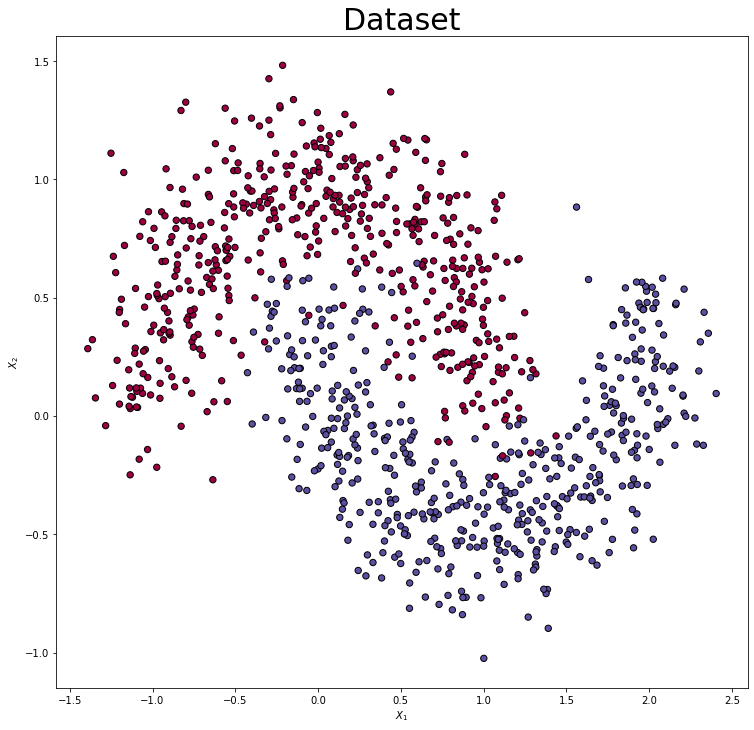

Test set accuracy: 0.98 - David


In [1]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import cm

# 首先是标定神经网络的结构
NN_ARCHITECTURE = [{"input_dim": 2, "output_dim": 25, "activation": "relu"},
                   {"input_dim": 25, "output_dim": 50, "activation": "relu"},
                   {"input_dim": 50, "output_dim": 50, "activation": "relu"},
                   {"input_dim": 50, "output_dim": 25, "activation": "relu"},
                   {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"}]


def init_layers(nn_architecture, seed=99):
    """然后对权重进行初始化，为了保证每次计算的结果一致，初始化种子使用同样的值"""
    # 首先随机初始化种子
    np.random.seed(seed)
    # 初始化关键变量
    number_of_layers = len(nn_architecture)
    params_values = {}
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx+1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        # 对每一层，初始化W矩阵和向量b。要注意矩阵和向量的维度，因为
        params_values['W'+str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size)*0.1
        params_values['b'+str(layer_idx)
                      ] = np.random.randn(layer_output_size, 1)*0.1
    return params_values


def sigmoid(Z):
    """sigmoid激活函数"""
    return 1/(1+np.exp(-Z))


def sigmoid_backward(dA, Z):
    """sigmoid函数导数在反向传播时的作用"""
    sig = sigmoid(Z)
    return dA*sig*(1-sig)


def relu(Z):
    """relu激活函数"""
    return np.maximum(0, Z)


def relu_backward(dA, Z):
    """relu函数导数"""
    # copy=True意味着构建了一个数组dA的副本，即深拷贝
    dZ = np.array(dA, copy=True)
    # 直接令z<=0时的dz为0即可，剩下的相当于dA*1
    dZ[Z <= 0] = 0
    return dZ


def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    """单层前向传递函数"""
    Z_curr = np.dot(W_curr, A_prev)+b_curr
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception("Non-supported activation function")
    return activation_func(Z_curr), Z_curr


def full_forward_propagation(X, params_values, nn_architecture):
    """所有层前向传递"""
    # 构建一个变量存储后续反向传播所需的各层信息
    memory = {}
    # X是输入
    A_curr = X
    for idx, layer in enumerate(nn_architecture):
        # layer_idx从1开始计数
        layer_idx = idx+1
        A_prev = A_curr
        activ_function_curr = layer["activation"]
        W_curr = params_values["W"+str(layer_idx)]
        b_curr = params_values["b"+str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(
            A_prev, W_curr, b_curr, activ_function_curr)
        # memory中存储中间变量
        memory["A"+str(idx)] = A_prev
        memory["Z"+str(layer_idx)] = Z_curr
    return A_curr, memory


def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1/m*(np.dot(Y, np.log(Y_hat).T)+np.dot(1-Y, np.log(1-Y_hat).T))
    # 为什么要除去多余的维度？因为之前的计算导致的
    return np.squeeze(cost)


def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    """计算一层误差反向传播，输入dA_curr表示的是∂J/∂a^(l)，其中，l是指当前层。
    输出是损失函数对上一层l-1层神经元值以及本层l层权重和偏置的偏导"""
    # m表示的是样本个数
    m = A_prev.shape[1]
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    # 因为每个偏导都包含dZ_curr，因此先求它。dZ_curr表示的是∂J/∂Z^(l)，链式法则=∂J/∂a^(l) * f'(Z^(l))（对应项相乘）
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    # 接下来几项就是三个偏导，注意有样本的影响，维度和单一样本推导时有所不同
    dW_curr = np.dot(dZ_curr, A_prev.T)/m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True)/m
    dA_prev = np.dot(W_curr.T, dZ_curr)
    return dA_prev, dW_curr, db_curr


def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    """完整反向传播算法，给出所有参数偏导组成的完整梯度"""
    grads_values = {}
    # 在反向循环开始之前，给出最后输出的误差，初始化反向传播算法
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    dA_prev = -(np.divide(Y, Y_hat)-np.divide(1-Y, 1-Y_hat))
    # 因为是反向传播算法，因此循环顺序是从后往前
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev+1
        activ_function_curr = layer["activation"]

        dA_curr = dA_prev

        A_prev = memory["A"+str(layer_idx_prev)]
        Z_curr = memory["Z"+str(layer_idx_curr)]
        W_curr = params_values["W"+str(layer_idx_curr)]
        b_curr = params_values["b"+str(layer_idx_curr)]

        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values['dW'+str(layer_idx_curr)] = dW_curr
        grads_values['db'+str(layer_idx_curr)] = db_curr
    return grads_values


def update(params_values, grads_values, nn_architecture, learning_rate):
    """更新参数"""
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values['W'+str(layer_idx)] -= learning_rate * \
            grads_values['dW'+str(layer_idx)]
        params_values['b'+str(layer_idx)] -= learning_rate * \
            grads_values['db'+str(layer_idx)]
    return params_values


def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_accuracy_value(y_hat, y):
    """为了显示优化的过程，计算accuracy"""
    y_hat = convert_prob_into_class(y_hat)
    return (y_hat == y).all(axis=0).mean()


def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    """整体训练过程"""
    # 初始化神经网络参数
    param_values = init_layers(nn_architecture, 2)
    # 为了后续可视化优化过程，存储中间阶段优化结果
    cost_history = []
    accuracy_history = []
    # 按epoch循环训练神经网络
    for i in range(epochs):
        # 每一步里面，首先前向传播
        Y_hat, cashe = full_forward_propagation(
            X, param_values, nn_architecture)
        # 然后计算cost
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        # 然后反向传播
        grads_values = full_backward_propagation(
            Y_hat, Y, cashe, param_values, nn_architecture)
        # 得到梯度之后，更新参数
        param_values = update(param_values, grads_values,
                              nn_architecture, learning_rate)
        # 显示训练过程
        if (i % 50 == 0):
            if (verbose):
                print(
                    "Iteration:{:05}-cost:{:.5f}-accuracy:{:.5f}".format(i, cost, accuracy))
            if (callback is not None):
                callback(i, param_values)
    return param_values


# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1
X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42)


def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    """可视化数据集的函数"""
    plt.figure(figsize=(16, 12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape),
                     25, alpha=1, cmap=cm.Spectral)
        plt.contourf(XX, YY, preds.reshape(XX.shape),
                     levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40,
                cmap=plt.cm.Spectral, edgecolors='black')
    plt.show()
    if(file_name):
        plt.savefig(file_name)
        plt.close()


make_plot(X, y, "Dataset")
# Training
params_values = train(np.transpose(X_train), np.transpose(
    y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)
# Prediction
Y_test_hat, _ = full_forward_propagation(
    np.transpose(X_test), params_values, NN_ARCHITECTURE)
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(
    y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - David".format(acc_test))

## 交叉验证

交叉验证是模型调优过程中，很重要的一个环节。这里参考了：[模型调优：交叉验证，超参数搜索(复习17)](https://blog.csdn.net/cymy001/article/details/79120355)以及[交叉验证](https://www.jiqizhixin.com/graph/technologies/de51a6aa-a6c6-43b1-880f-79c0b033bbae)来记录一点基本概念。

用模型在测试集上进行性能评估前，通常是希望**尽可能利用手头现有的数据对模型进行调优**，甚至可以**粗略地估计测试结果**。

交叉验证，有时亦称循环估计， 是一种统计学上将数据样本切割成较小子集的实用方法。于是可以**先在一个子集上做分析， 而其它子集则用来做后续对此分析的确认及验证**。 一开始的子集被称为训练集。而其它的子集则被称为验证集或测试集。交叉验证的目标是定义一个数据集到“测试”的模型在训练阶段，**以便减少像过拟合的问题**，得到该模型将如何衍生到一个独立的数据集的提示。

交叉验证可以**保证所有数据都有被训练和验证的机会**，也尽最大可能让优化的模型性能表现的更加可信。

K次交叉验证（k-fold cross-validation）是一种常用的方式，将**训练集分割成K个子样本，一个单独的子样本被保留作为验证模型的数据，其他K-1个样本用来训练**。交叉验证重复K次，每个子样本验证一次，平均K次的结果或者使用其它结合方式，最终得到一个单一估测。这个方法的优势在于，同时重复运用随机产生的子样本进行训练和验证，每次的结果验证一次，10次交叉验证是最常用的。

交叉验证可用于**比较不同预测建模程序的性能**。注意它其实是用来判断模型性能以及选取参数的。因此确定好参数之后，就确定了模型，再重新用这个模型去训练预测就行了。

可以使用scikit-learn调用pytorch生成的模型。

这里推荐尝试下skorch库，可以很方便地结合使用pytorch和sklearn。

## Early Stoping

本文主要参考了：[深度学习 ： 提前终止](https://www.zybuluo.com/songying/note/1400484)，[早停法](https://deeplearning4j.org/cn/earlystopping)等，主要了解下深度学习中如何自动确定epoch。

early stoping 是一种正则化方式，其可以单独使用或与其他正则化策略一起使用。

early stoping 的步骤如下：

1. 将训练数据划分为训练集和测试集
2. 仅仅在训练集上训练，并在一段时间间隔内在测试集上预测
3. 当验证集上的误差高于上次时立即停止训练。
4. 使用上一时刻中所得的权重来作为最终权重

在这个过程中，验证集实际上是作为评测模型泛化误差的估计值。

early stoping带来了两个额外的代价;

1. 需要不时的来通过验证集来评估泛化误差以估算最佳的训练时间
2. 需要保持最佳的参数副本

为什么采用 early stoping？因为训练误差会随着时间的推移逐渐降低但验证集的误差却再次上升，这意味着模型发生了过拟合，此时可以采用early stoping 来获取在验证集上表现最佳的参数。

![](006gOeiSly1fznpq1o35fj30ko0b274g.jpg)

在现实中，我们往往不能获得像上图中那么漂亮的曲线，我们获得的曲线往往是这样的：

![](006gOeiSly1fznprr4czqj30k10biq3c.jpg)

实际中，验证集误差**往往有多个局部极小值点**，这阻碍了我们选择最佳的参数位置。何时停止实际上是**对训练时间和泛化误差之间的权衡**，我们的目的就是**选择一个何时的标准**。

Stopping 策略如下所述。

- $E$: 目标函数
- $E_{tr}(t)$： t个epoch之后的训练集平均误差
- $E_{va}(t)$： t个epoch之后的验证集平均误差
- $E_{te}(t)$: t个epoch之后的测试集平均误差
- $E_{opt}(t)=min_{t'<=t}E_{va}(t')$: t个epoch 之内的最低验证集平均误差
- $GL(t)=100*(\frac{E_{va}(t)}{E_{opt}(t)}-1)$: t个epoch 中的泛化损失，泛化损失越高，表明过拟合程度越高。

1. 第一个策略：当泛化损失大于某个阈值时立即停止： 
$GL_{\alpha}$:stop after first epoch t with $GL(t)>\alpha$
2. 第二个策略：有时，第一个策略生效时训练误差依旧在快速减小，而我们假定过拟合仅仅发生在训练误差变化缓慢时。我们采用k来表示 k 个epoch 间隔，此时有:
$$P_k(t)=1000*(\frac{\sum_{t'=t-k+1}^{t}E_{tr}(t')}{k*min^t_{t'=t-k+1}E_{tr}(t')}-1)$$
$PQ_\alpha$：stop after first end-of-strip epoch t with $\frac{GL(t)}{P_k(t)}>\alpha$
3. 第三个策略：当s个连续时刻的泛化误差增大时停止。该策略假设当验证集平均误差不仅增加了一次，而且在连续多个时刻增加时，这表明过拟合的开始，与实际增加的多少无关。
$UP_s$：srop after epoch t if $UP_{s-1}$ stops after epoch t-k and $E_{va}(t)>E_{va}(t-k)$

那么到底如何选择策略

一般而言，slower 标准比 faster 标准能够更好的提高泛化。

- 除非网络性能的小改进比训练时间更重要，否则选择第一个策略
- 为了找到最好方案，选择GL（最好）
- 为了找到平均方案，use a PQ criterion if the network overfits only very little or an UP criterion otherwise.